We have solved a simplified version of this problem already, using a different method, here: 
https://grainofsandendlessbeach.blogspot.com/2024/08/polygon-obstacle-path-finder-chapter-3.html

Previously (link above) we created a graph by finding all vertices visible from a particular vertex, for all vertices. Once the graph was fully formed, we ran a few graph search algorithms on it to find a path from the start to the end. Obviously A-star and uniform-cost search (dijkstra) found the shortest path (the red and green lines). Here we are taking a different approach: We are asked in Exercise 4.11 to turn this problem into an environment problem. No longer do we form a graph by fully surveying the problem then running an algorithm on the graph to obtain a solution. This time we are asked to provide an agent with percepts in the form of a collection of visible vertices. The agent then makes a decision on what action to take: this comes in the form of a vector describing a straight-line path to follow.

One of the difficulties in this version of the problem is that we have to take into account the size of the agent. For simplicity I am going to assume that the agent is circular. If this was not the case then it is a decent assumption to assume that the agent is bounded by a circular region. In the original problem (3.7, linked above) the agent was a point mass so we did not have to make a distinction between visbility and reachability. This time we are searching for collision between a disk and an obstacle, during the execution of an action. This is commonly referred to as swept collision detection.

If you want to run this code, look for `polygon_env.ipynb`, here: 
https://github.com/hmp-anthony/AIMA

## My Idea

Since this is now an environment problem, we have to obtain percepts and execute actions via an agent program. Obtaining percepts is relatively easy. We just find all the vertices that are visible to the agent: we can eliminate a vast majority of vertices by checking which side of a "visibility plane" the vertex is on. Because the agent has some size, we have to take this into account when travelling to a vertex. That is, we need to take care when executing actions. I do this by taking the target vertex and the agents current position and form a line that goes from the current position to the target vertex and discretise it. At each point along that line I check the intersection between the agents exterior (a circle) and all visible line segments formed by adjacent vertices. Again, we only need to check vertices that are on the correct side of a "visibility plane".


In [26]:
from search_2 import *
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from agents import *

class vertex:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.goal = False
        
    def __repr__(self):
        return "(" + str(self.x) + ", " + str(self.y) + ")"
        
    def __add__(self, other):
        return vertex(self.x + other.x, self.y + other.y)

    def __sub__(self, other):
        return vertex(self.x - other.x, self.y - other.y)

    def __mul__(self, other):
        if(isinstance(other, vertex)):
            return self.x * other.x + self.y * other.y
        if(isinstance(other, float) or isinstance(other, int)):
            return vertex(self.x * other, self.y * other)

    def __eq__(self, other):
        if(isinstance(other, vertex)):
            return self.x == other.x and self.y == other.y
        return False

    __rmul__ = __mul__

    def cross(self, other):
        return self.x * other.y - self.y * other.x

    def normalize(self):
        mag = math.sqrt(self.x*self.x + self.y*self.y)
        self.x *= 1/mag
        self.y *= 1/mag

    def length(self):
        return math.sqrt(self.x*self.x + self.y*self.y)

class polygon:
    # vertices are passed in the order they appear if
    # you were to walk around the vertices.
    def __init__(self, vertices):
        self.vertices = vertices

    def get_vertices(self):
        return self.vertices

    def intersect(self, begin, end):
        vs = self.vertices
        p = begin
        r = end - begin
        for i in range(len(vs)):
            q = vs[i]
            if i < len(vs) - 1:
                s = vs[i+1] - vs[i]
            else:
                s = vs[0] - vs[i]
            rxs = r.cross(s)
            qmp = q - p
            # if r and s are parallel
            if 0 <= rxs < 0.0001:
                # collinear and trivially intersecting
                if(abs(qmp.cross(s)) < 0.0001 or abs(qmp.cross(r)) < 0.0001):
                    return True
                # parallel and not intersecting
                return False
            u = qmp.cross(r) / rxs
            t = qmp.cross(s) / rxs
            if 0 < u < 1 and 0 < t < 1:
                return True
        return False

def create_goal():
    r_x = random.uniform(0,19)
    r_y = random.uniform(0,19)
    v1 = vertex(r_x, r_y)
    v1.goal = True
    v2 = vertex(r_x + 1, r_y)
    v2.goal = True
    v3 = vertex(r_x + 1, r_y + 1)
    v3.goal = True
    v4 = vertex(r_x, r_y + 1)
    v4.goal = True
    return polygon([v1,v2,v3,v4])



class PolygonAgent(Agent):
    def __init__(self, program = None):
        super().__init__(program)
        # a pair of vertices, [vertex(n1, n2), vertex(x0, y0)], where
        # (n1, n2) is a normal and (x0, y0) is a point on the line.
        self.visibility_plane = None
        self.size = 0.5
        self.steps_since_goal = 0

# program takes percepts and spits out actions
def program(percept):
    # we take in a vector of vertices
    if len(percept) > 0:
        return random.choice(percept)
    print("failure")
    return vertex(random.unifrom(1,15),random.uniform(1,15))

class Environment:
    def __init__(self, polygons, agent, initial_position):
        self.agent = agent
        self.agent_position = initial_position
        self.polygons = polygons
        self.path = []

    def percept(self):
        # We need to find all visible vertices.
        vertices = []
        for p in self.polygons:
            vertices.extend(p.get_vertices())
        visible_vertices = []
        for v in vertices:
            visible = True
            if self.agent.visibility_plane:
                n = self.agent.visibility_plane[0]
                x = self.agent.visibility_plane[1]
                # the vertex is on the wrong side of the vis-plane
                if (v - x) * n < 0:
                    continue
            # the line segment from agent to vertex
            for p in self.polygons:
                if p.intersect(self.agent_position, v):
                    visible = False
                    break
            if(visible):
                visible_vertices.append(v)
                if(v.goal):
                    agent.performance += 1000
                    polygons[-1] = create_goal()
                    print("moving goal", v)
                    agent.steps_since_goal = 0
                    break
        return visible_vertices

    def execute_action(self, action):
        if isinstance(action, vertex):
            self.move_agent(action)

    def intersect(self, center, r):
        for p in self.polygons:
            vs = p.vertices
            for i in range(len(vs)):
                s = vs[i]
                if i < len(vs) - 1:
                    e = vs[i+1] - vs[i]
                else:
                    e = vs[0] - vs[i]
                if(self.agent.visibility_plane):
                    n = self.agent.visibility_plane[0]
                    x = self.agent.visibility_plane[1]
                    if (vs[i] - x) * n < 0 and ((e + vs[i]) - x) * n < 0:
                        continue
                a = s.x - center.x
                b = e.x
                c = s.y - center.y
                d = e.y
                A = b*b + d*d
                B = 2*(a*b + c*d)
                C = a*a + c*c - r*r
                D = B*B - 4*A*C
                if(D >= 0):
                    z1 = (-B + math.sqrt(D))/(2 * A)
                    z2 = (-B - math.sqrt(D))/(2 * A)
                    if(0 <= z1 <= 1 or 0 <= z2 <= 1):
                        return [s + z1*e, s + z2*e]
                        
    
    def move_agent(self, location):
        v = self.agent_position
        w = location - self.agent_position
        r = self.agent.size
        t = 0
        for T in range(1000):
            center = v + t * w
            intersections = self.intersect(center, r)
            if(intersections):
                contact = 0.5 * (intersections[0] + intersections[1])
                self.agent_position = center
                self.path.append(center)
                self.agent.performance -= (self.path[-2] - self.path[-1]).length()
                normal = center - contact
                normal.normalize()
                self.agent.visibility_plane = [normal, center]
                self.agent.steps_since_goal += 1
                if(self.agent.steps_since_goal > 20):
                    polygons[-1] = create_goal()
                    print("moving goal, steps limit reached", v)
                    self.agent.steps_since_goal = 0
                break
            t += 0.001
    
    def step(self):
        action = agent.program(self.percept())
        self.execute_action(action)

    def run(self, steps=200):
        for step in range(steps): 
            self.step()

moving goal (6.59975231313771, 7.746208750600141)
moving goal (3.994416271087621, 3.7289647878935055)
moving goal (14.901233135146118, 14.269968404607242)
moving goal (13.033923829427948, 16.285001767186255)
moving goal (2.7267998219464653, 1.5497407718148697)
moving goal (13.623401653293392, 11.235584271903603)
moving goal (8.897876533678122, 8.905465716418796)
moving goal (6.5444003500031585, 12.785582403979847)
moving goal (6.185522187858737, 12.37737628628811)
moving goal, steps limit reached (14.180096085778272, 16.502150752635217)
moving goal (10.512893404388404, 9.075417528751768)
moving goal (12.60842916711657, 3.9209983300731026)
moving goal (2.0467697415975916, 12.461663227881292)
moving goal (12.710842769127101, 4.415921713631047)
moving goal (13.601063592255567, 13.431572382593918)
moving goal, steps limit reached (12.498810001785316, 7.929378427175079)
moving goal (17.07136124289639, 14.449913054299646)
moving goal (14.182034457219439, 10.074151888161513)
moving goal (15.1

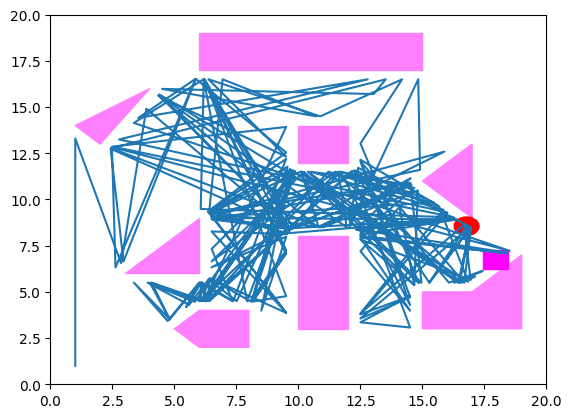

In [27]:
polygons = [polygon([vertex(6,2), vertex(8,2), vertex(8,4), vertex(6,4), vertex(5,3)]),
            polygon([vertex(3,6), vertex(6,6), vertex(6,9)]),
            polygon([vertex(10,3), vertex(12,3), vertex(12,8), vertex(10,8)]),
            polygon([vertex(2,13), vertex(4,16), vertex(1,14)]),
            polygon([vertex(10,12), vertex(12,12), vertex(12,14), vertex(10,14)]),
            polygon([vertex(15,11), vertex(17,9), vertex(17,13)]),
            polygon([vertex(6,17), vertex(15,17), vertex(15,19), vertex(6,19)]),
            polygon([vertex(15,3), vertex(19,3), vertex(19,7), vertex(17,5), vertex(15,5)])]

initial_position = vertex(1,1)
polygons.append(create_goal())

agent = PolygonAgent(program)

env = Environment(polygons, agent, initial_position)
env.path.append(vertex(1,1))
env.run()

polygon_data = []
for p in polygons:
    vertex_list = p.get_vertices()
    vertex_list_tuples = [(v.x, v.y) for v in vertex_list]
    if vertex_list[0].goal:
        plot_p = Polygon(vertex_list_tuples, color=[1, 0, 1])
    else:
        plot_p = Polygon(vertex_list_tuples, color=[1, 0.5, 1])
    polygon_data.append(plot_p)

fig,ax = plt.subplots()

for p in polygon_data:
    ax.add_patch(p)

circle1 = plt.Circle((env.agent_position.x, env.agent_position.y), agent.size, color='r')
plt.gca().add_patch(circle1)

path_x = []
path_y = []
for p in env.path:
    path_x.append(p.x)
    path_y.append(p.y)

print("performance", agent.performance)

ax.plot(path_x, path_y)

ax.set_xlim([0,20])
ax.set_ylim([0,20])

plt.show()


I think to myself: If this agent was a Roomba, I would be a happy man. The light pink polygons are the obstacles. The small dark pink square is the obstacle. In the text output above the image we can see that the agent frequently find its goal. A score of ~39k is pretty good.